# NNTI Assignment 5

Name 1: Mahsa Amani <br>
Student id 1: 7064006 <br>
Email 1: maam00002@stud.uni-saarland.de <br>

Name 2: Sayeh Jarollahi<br>
Student id 2: 7073520<br>
Email 2:  saja00006@stud.uni-saarland.de<br>

# Exercise 5.4 - Feedforward Neural Network (3 points)

In the lecture, you were introduced to some problems that can be solved with a two-layer neural network but not with a single-layer one. In this practical exercise, let's try solving such a problem together and get familiar with building and training models using PyTorch.

## Import libraries

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.cm as cm 

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

## Generating Data

Here, we generate a dataset consisting of 3 classes in 2 dimensional space, where no two classes are linearly separable.

In [2]:
np.random.seed(352)
torch.manual_seed(0)

N = 100 # number of points per class
C = 3 # number of classes

def generate_data(N, num_class):
    X = np.zeros((2, N*num_class)) # data matrix 
    y = np.zeros(N*num_class) # class abels

    for j in range(num_class):
        ix = range(N*j,N*(j+1))
        r = np.linspace(0.0, 1, N) # radius
        t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
        X[:,ix] = np.c_[r*np.sin(t), r*np.cos(t)].T
        y[ix] = j

    return X.T, y

# Generate data
data, labels = generate_data(N, C)

# Uncomment to see the shape of data and labels
print("Data shape :", data.shape)
print("Labels shape :", labels.shape)


Data shape : (300, 2)
Labels shape : (300,)


At this point let's visualize the dataset we just generated.

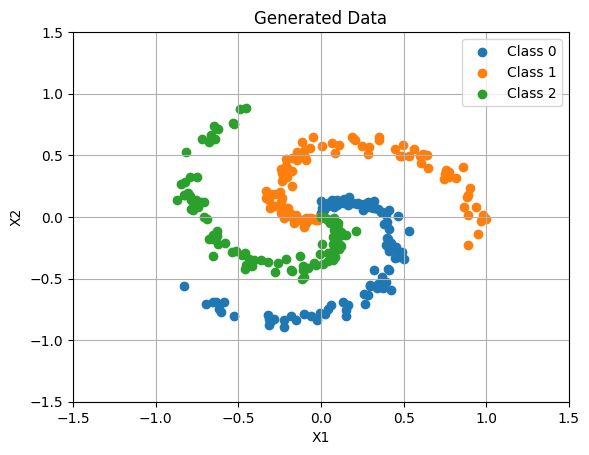

In [3]:
for i in range(C):
  plt.scatter(data[i*N:(i+1)*N, 0], data[i*N:(i+1)*N, 1], label=('Class ' + str(i)))

plt.xlim([-1.5, 1.5])
plt.ylim([-1.5, 1.5])
plt.title("Generated Data")
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend()
plt.grid(True)
plt.show()
    

## 5.4.1 DataLoader (0.5 points)

Complete the PointDataset by replacing ```NotImplemented``` with your code 


In [4]:
class PointsDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.tensor(data, dtype=torch.float)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __getitem__(self, index):
        point = self.data[index]
        label = self.labels[index]
        return point, label

    def __len__(self):
        return len(self.labels)

class PointsDataLoader(DataLoader):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.transform = lambda x: x   
        
    def __iter__(self):
        for batch in super().__iter__():
            yield self.transform(batch)

## 5.4.2 Building our 2-layer neural network (0.5 points)

<p align="center"> <img src="https://www.ritchievink.com/img/post-9-mlp/nn_diagram_1.png" alt="nn" style="width: 700px;"/> </p>


In this exercise, you are required to complete a model using the layers provided by PyTorch. To complete this exercise, you can refer to the following: [Building Models with PyTorch](https://pytorch.org/tutorials/beginner/introyt/modelsyt_tutorial.html). Our model will be described as consisting of the following components: 

Linear Layer: $$\mathbf{Z}^{(2)} = \mathbf{W}^{(1)T}\mathbf{X} $$

ReLU Activation: $$\mathbf{A}^{(2)} = \max(\mathbf{Z}^{(2)}, \mathbf{0}) $$

Linear Layer:$$\mathbf{Z}^{(3)} = \mathbf{W}^{(2)T}\mathbf{A}^{(1)} $$

Softmax Activation:$$\mathbf{\hat{Y}} = \mathbf{A}^{(3)} = \text{softmax}(\mathbf{Z}^{(3)})$$


In [5]:
class FFNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim) -> None:
        super(FFNN, self).__init__()
        # Fill in the layers provided by PyTorch that correspond to the description.
        self.linear1 = torch.nn.Linear(input_dim, hidden_dim)
        self.activation = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(hidden_dim, output_dim)
        self.softmax = torch.nn.Softmax()

    def forward(self, x):
        # Perform the forward pass of the model
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        x = self.softmax(x)
        return x

## 5.4.3 Train our model (1 point)

Here, we specify the important hyperparameters for training the model as well as provide a function to plot the decision boundary to help visualize the results after training.

In [6]:
config = {
    "input_dim": 2,
    "hidden_dim": 100,
    "output_dim": C,
    "device": torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"),
    "num_epochs": 1000,
    "batch_size": 300,
    "learning_rate": 1,
}

In [7]:
# Visualize function
def plot_decision_boundary(model, points, labels, title="Decision Boundary"):
    model.eval()
    plt.figure(figsize=(8, 6))
    
    # Plot the data points
    for label in np.unique(labels):
        label_points = points[labels.flatten() == label]
        plt.scatter(label_points[:, 0], label_points[:, 1], label=('Class ' + str(int(label))))
    
    # Create grid to evaluate the model
    x_min, x_max = points[:, 0].min() - 1, points[:, 0].max() + 1
    y_min, y_max = points[:, 1].min() - 1, points[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    X0 = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float)
    Z = model(X0).argmax(dim=1)
    Z = Z.reshape(xx.shape)
    
    # Plot decision boundary
    plt.contourf(xx, yy, Z, alpha=0.2, cmap=plt.cm.coolwarm)
    plt.title(title)
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.legend()
    plt.grid(True)
    plt.show()

<b>(1 point) Complete the train function below to train the model. </b>

To complete this exercise, you can refer [Training with PyTorch](https://pytorch.org/tutorials/beginner/introyt/trainingyt.html#the-training-loop) for a more detailed understanding.

In [8]:
def train(config, data, labels):
    # Create out data loader
    points_dataset = PointsDataset(data, labels)
    points_dataloader = PointsDataLoader(points_dataset, batch_size=config["batch_size"], shuffle=True)

    # Init our model 
    model = FFNN(config["input_dim"], config["hidden_dim"], config["output_dim"])
    model.to(config["device"])

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=config["learning_rate"])

    model.train()
    for epoch in range(config["num_epochs"]):
        running_loss = 0
        correct = 0

        for batch_point, batch_label in points_dataloader:
            batch_point = batch_point.to(config["device"])
            batch_label = batch_label.to(config["device"])
            
            ####################  TODOs   #########################
            # Compute the output of the model and compute the loss
            output = model(batch_point)
            loss = criterion(output, batch_label)

            ##########  TODOs   #########
            # Zero your gradients for every batch
            # Compute the gradients of loss
            # Adjust learning weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            ##############################
            
            running_loss += loss.item()
            correct += (output.argmax(1) == batch_label).sum().item()

        if (epoch + 1) % 100 == 0:
            print(f'Epoch {epoch+1} | Running Loss: {running_loss/len(points_dataloader)} | Accuracy: {correct/len(points_dataset)}')
            
    plot_decision_boundary(model, data, labels, title="Decision Boundaries")



/Users/mahsaamani/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 100 | Running Loss: 0.8401603698730469 | Accuracy: 0.6633333333333333
Epoch 200 | Running Loss: 0.7595046758651733 | Accuracy: 0.7766666666666666
Epoch 300 | Running Loss: 0.7039984464645386 | Accuracy: 0.8833333333333333
Epoch 400 | Running Loss: 0.6738969087600708 | Accuracy: 0.9166666666666666
Epoch 500 | Running Loss: 0.6558574438095093 | Accuracy: 0.9333333333333333
Epoch 600 | Running Loss: 0.6431346535682678 | Accuracy: 0.9366666666666666
Epoch 700 | Running Loss: 0.6333969831466675 | Accuracy: 0.95
Epoch 800 | Running Loss: 0.625477135181427 | Accuracy: 0.95
Epoch 900 | Running Loss: 0.6189146041870117 | Accuracy: 0.9566666666666667
Epoch 1000 | Running Loss: 0.6132679581642151 | Accuracy: 0.9633333333333334


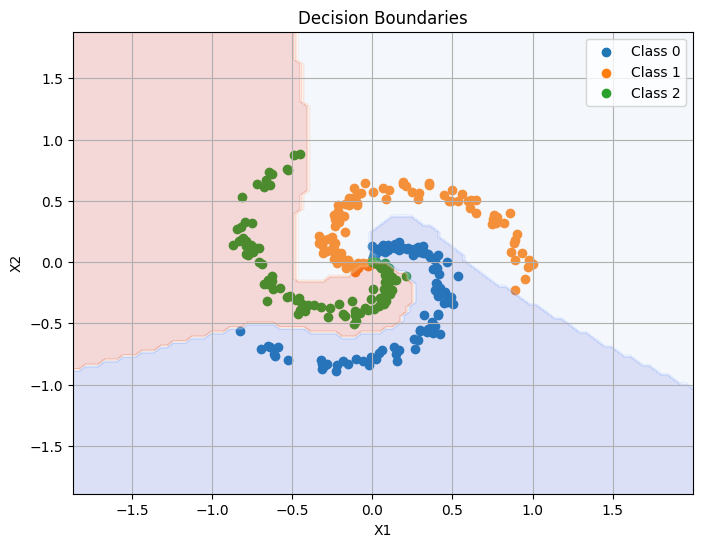

In [9]:
model = train(config, data, labels)

## 5.4.4 Let's do some experiments. (1 point)

<b> (0.5 points) Train the model again with ```config_1``` and explain what you observe. Provide an explanation for your observation (maximum 2 sentences). </b>

With the hyperparameters provided in ```config``` , we changed ```hidden_dim``` from 100 to 5.

In [10]:
config_1 = {
    "input_dim": 2,
    "hidden_dim": 5,
    "output_dim": C,
    "device": torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"),
    "num_epochs": 1000,
    "batch_size": 300,
    "learning_rate": 1,
}

Epoch 100 | Running Loss: 0.9916316866874695 | Accuracy: 0.5333333333333333
Epoch 200 | Running Loss: 0.8871389031410217 | Accuracy: 0.6466666666666666
Epoch 300 | Running Loss: 0.8503427505493164 | Accuracy: 0.7366666666666667
Epoch 400 | Running Loss: 0.8221355080604553 | Accuracy: 0.7566666666666667
Epoch 500 | Running Loss: 0.8050215840339661 | Accuracy: 0.77
Epoch 600 | Running Loss: 0.7939465045928955 | Accuracy: 0.7766666666666666
Epoch 700 | Running Loss: 0.7858286499977112 | Accuracy: 0.7933333333333333
Epoch 800 | Running Loss: 0.7794409990310669 | Accuracy: 0.8
Epoch 900 | Running Loss: 0.7741913199424744 | Accuracy: 0.81
Epoch 1000 | Running Loss: 0.7697529196739197 | Accuracy: 0.8166666666666667


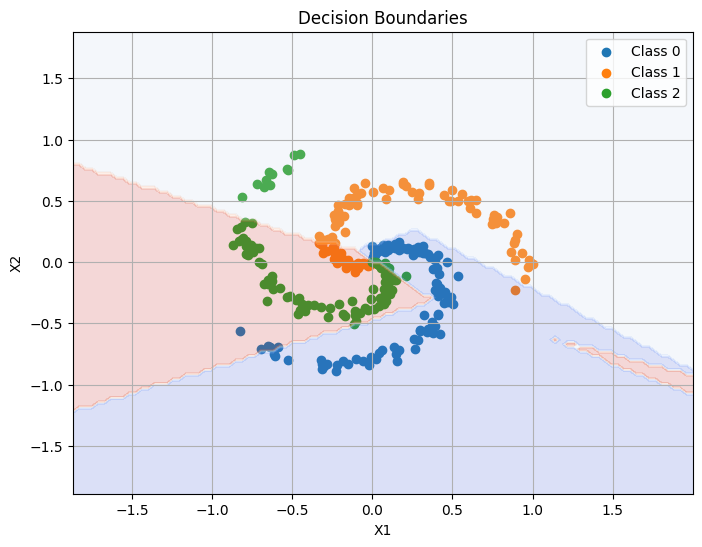

In [11]:
# Run this cell to train the model with config_1 
train(config_1, data, labels)

Your answer:

- What do you observe? We can see that with lower hidden dimension, model is not able to accurately classify the points and its accuracy has been decreased.

- Explain your observation: Decreasing the hidden layer dimension leads to a simpler model with less representational power. For this dataset, which requires complex decision boundaries, such a network will struggle to classify the data points accurately. Introducing additional layers might help.

<b> (0.5 points) Train the model again with ```config_2``` below and explain what you observe. Provide an explanation for your observation (maximum 2 sentences). </b>

Epoch 100 | Running Loss: 1.218111515045166 | Accuracy: 0.3333333333333333
Epoch 200 | Running Loss: 1.218111515045166 | Accuracy: 0.3333333333333333
Epoch 300 | Running Loss: 1.218111515045166 | Accuracy: 0.3333333333333333
Epoch 400 | Running Loss: 1.218111515045166 | Accuracy: 0.3333333333333333
Epoch 500 | Running Loss: 1.218111515045166 | Accuracy: 0.3333333333333333
Epoch 600 | Running Loss: 1.218111515045166 | Accuracy: 0.3333333333333333
Epoch 700 | Running Loss: 1.218111515045166 | Accuracy: 0.3333333333333333
Epoch 800 | Running Loss: 1.218111515045166 | Accuracy: 0.3333333333333333
Epoch 900 | Running Loss: 1.218111515045166 | Accuracy: 0.3333333333333333
Epoch 1000 | Running Loss: 1.218111515045166 | Accuracy: 0.3333333333333333


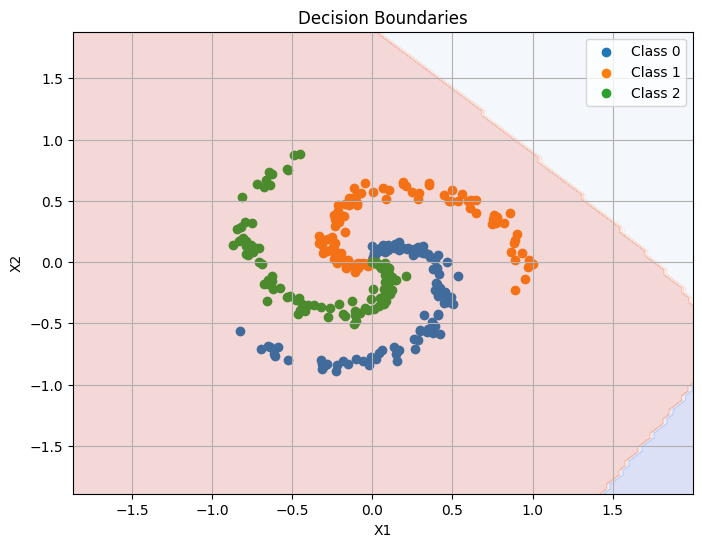

In [12]:
# In config_2, we keep the hyperparameters the same as in the config, except for increasing the learning rate from 1 to 100.
config_2 = {
    "input_dim": 2,
    "hidden_dim": 100,
    "output_dim": C,
    "device": torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"),
    "num_epochs": 1000,
    "batch_size": 300,
    "learning_rate": 100,
}
# Train the model with config_2  
train(config_2, data, labels)

Your answer:

- What do you observe? With increasing the learning rate from 1 to 100, model's performance has dropped significantly. Also the loss and accuracy has not changed over 1000 epochs, and no convergence is seen.


- Explain your observation: This is because of high learning rate that causes the optimization algorithm to overshoot the optimal parameter values and prevents the model from converging to the minima of the loss function. For deeper networks, a large learning rate amplifies the risk of exploding gradients. This occurs because large updates amplify gradient magnitudes and lead to unstable parameter values (for this problem, one solution would be to use gradient clipping). 
This also highlights the importance of careful hyperparameter tuning, particularly the learning rate, to ensure that the optimization algorithm can effectively minimize the loss function.

